In [ ]:
# import gpflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
# import tensorflow as tf
from pymc3.gp.util import plot_gp_dist
import pymc3 as pm
# import datashader as ds
# import datashader.transfer_functions as tf
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from sklearn import gaussian_process, metrics
from sklearn.gaussian_process import kernels
from sklearn.gaussian_process import GaussianProcessRegressor
import arviz as az
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
%matplotlib inline

from scipy.stats import beta, uniform

np.random.seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/function-learning/experiments")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
argmax_r1 = beta.pdf(13/15, 131, 21)
argmax_r2 = beta.pdf(3/14, 31, 111)
argmax_r3 = beta.pdf(14/26, 141, 121)
argmax_r4 = beta.pdf(0.78, 131, 40)

argmax_s1 = beta.pdf(0, 1, 3)
argmax_s2 = beta.pdf(2/3, 3, 2)
argmax_s3 = beta.pdf(1, 2.5, 1)
argmax_s4 = beta.pdf(1/4, 1.5, 2.5)

def rough_1(x):
    return (beta.pdf(x, 131, 21) * 2/3) / argmax_r1 + 0.08333

def rough_2(x):
    return (beta.pdf(x, 31, 111) * 2/3) / argmax_r2 + 0.16666

def rough_3(x):
    return (beta.pdf(x, 141, 121) * 2/3) / argmax_r3 + 0.243333

def rough_4(x):
    return (beta.pdf(x, 131, 40) * 2/3) / argmax_r4 + 0.3333

def smooth_1(x):
    return (beta.pdf(x, 1, 3) * 2/3) / argmax_s1 + 0.08333

def smooth_2(x):
    return (beta.pdf(x, 3, 2) * 2/3) / argmax_s2 + 0.16666

def smooth_3(x):
    return (beta.pdf(x, 2.5, 1) * 2/3) / argmax_s3 + 0.243333

def smooth_4(x):
    return (beta.pdf(x, 1.5, 2.5) * 2/3) / argmax_s4 + 0.3333

def flat(x):
    return 0.5 + 0 * x

def chocolate(x):
    return (0.4 * x + 0.2)

In [ ]:
def load_samples(function, uid=None):
    x_t = np.linspace(0, 1, 500)
    samples = pd.read_csv("../analysis/function_020samples.csv")
    
    dict_of_samples = dict(tuple(samples.groupby('name')))
    names = samples["name"].unique()
    if uid is not None:
        samples = dict_of_samples[names[uid]]
    
    r1_samples = samples[samples["seaName"] == "rough_1"]
    r2_samples = samples[samples["seaName"] == "rough_2"]
    r3_samples = samples[samples["seaName"] == "rough_3"]
    r4_samples = samples[samples["seaName"] == "rough_4"]
    s1_samples = samples[samples["seaName"] == "smooth_1"]
    s2_samples = samples[samples["seaName"] == "smooth_2"]
    s3_samples = samples[samples["seaName"] == "smooth_3"]
    s4_samples = samples[samples["seaName"] == "smooth_4"]
    flat_samples = samples[samples["seaName"] == "flat"]
    
    if function == "rough_1":
        samples, y_t = r1_samples, rough_1(x_t)
    if function == "rough_2":
        samples, y_t = r2_samples, rough_2(x_t)
    if function == "rough_3":
        samples, y_t = r3_samples, rough_3(x_t)
    if function == "rough_4":
        samples, y_t = r4_samples, rough_4(x_t) 
    if function == "smooth_1":
        samples, y_t = s1_samples, smooth_1(x_t)
    if function == "smooth_2":
        samples, y_t = s2_samples, smooth_2(x_t)
    if function == "smooth_3":
        samples, y_t = s3_samples, smooth_3(x_t)
    if function == "smooth_4":
        samples, y_t = s4_samples, smooth_4(x_t)     
    if function == "flat":
        samples, y_t = flat_samples, flat(x_t)
        

    
    return {"Samples": samples, "Targets": y_t}

def load_preds(function, uid=None):
    
    preds = pd.read_csv("../analysis/function_020preds.csv")
    
    dict_of_preds = dict(tuple(preds.groupby('name')))
    names = preds["name"].unique()
    if uid is not None:
        preds = dict_of_preds[names[uid]]
        
    r1_preds = preds[preds["seaName"] == "rough_1"]
    r2_preds = preds[preds["seaName"] == "rough_2"]
    r3_preds = preds[preds["seaName"] == "rough_3"]
    r4_preds = preds[preds["seaName"] == "rough_4"]
    s1_preds = preds[preds["seaName"] == "smooth_1"]
    s2_preds = preds[preds["seaName"] == "smooth_2"]
    s3_preds = preds[preds["seaName"] == "smooth_3"]
    s4_preds = preds[preds["seaName"] == "smooth_4"]
    flat_preds = preds[preds["seaName"] == "flat"]
    
    if function == "rough_1":
        preds = r1_preds
    if function == "rough_2":
        preds = r2_preds
    if function == "rough_3":
        preds = r3_preds
    if function == "rough_4":
        preds = r4_preds  
    if function == "smooth_1":
        preds = s1_preds
    if function == "smooth_2":
        preds = s2_preds
    if function == "smooth_3":
        preds = s3_preds
    if function == "smooth_4":
        preds = s4_preds      
    if function == "flat":
        preds = flat_preds
        
    return {"Predictions": preds}

In [ ]:
load_samples("flat", 80)["Samples"]["x"].values.reshape(-1, 1)
load_preds("flat", 80)["Predictions"]["x"].values.reshape(-1, 1)

array([[0.0015625],
       [0.003125 ],
       [0.0046875],
       [0.009375 ],
       [0.0171875],
       [0.0296875],
       [0.0390625],
       [0.05     ],
       [0.0625   ],
       [0.071875 ],
       [0.0828125],
       [0.0921875],
       [0.1015625],
       [0.1109375],
       [0.1203125],
       [0.128125 ],
       [0.1359375],
       [0.1421875],
       [0.1484375],
       [0.153125 ],
       [0.1609375],
       [0.1703125],
       [0.178125 ],
       [0.1859375],
       [0.19375  ],
       [0.2015625],
       [0.209375 ],
       [0.2171875],
       [0.2265625],
       [0.234375 ],
       [0.24375  ],
       [0.25     ],
       [0.2578125],
       [0.2640625],
       [0.2734375],
       [0.2765625],
       [0.2875   ],
       [0.29375  ],
       [0.3015625],
       [0.309375 ],
       [0.3171875],
       [0.328125 ],
       [0.3390625],
       [0.346875 ],
       [0.3578125],
       [0.365625 ],
       [0.375    ],
       [0.38125  ],
       [0.3890625],
       [0.3984375],


In [ ]:
print(int(np.random.randint(1, 3, 1)))

1


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#     Define simulated sampling strategies and GP fits    #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
K = kernels.Matern()
MIN = 0
MAX = 1

from scipy.special import logit, expit

def uniform_sample(num):
    return np.random.uniform(MIN, MAX, size=(num, 1))

def sequential_sample(num):
    v = []
    for i in range(num):
        alpha = 1 + 25 * i / (num - 1)
        beta = 1 + 25 * (num - 1 - i) / (num - 1)
        v.append(np.random.beta(alpha, beta))
    x = np.array(v)
    return x.reshape(-1, 1)

def resample_seq(num, objective_func):
    v = []
    shift=int(np.random.randint(1, num-3, 1))
    # Generate num-shift random samples
    for i in range(num-shift):
        alpha = 1 + 25 * i / (num - 1)
        beta = 1 + 25 * (num - 1 - i) / (num - 1)
        v.append(np.random.beta(alpha, beta))
    x = np.array(v).reshape(-1,1)
    max_x = float(x[np.argmax(objective_func(x))])
    epsilon=0.25
    # Go back and sample points near max
    for j in range(shift):
        l = logit(max_x)
        noise=np.random.uniform(l-0.5, l+0.5)
        v.append(expit(noise))
    return np.array(v).reshape(-1,1)


def sequential_sample(num):
    v = []
    for i in range(num):
        alpha = 1 + 25 * i / (num - 1)
        beta = 1 + 25 * (num - 1 - i) / (num - 1)
        v.append(np.random.beta(alpha, beta))
    x = np.array(v)
    return x.reshape(-1, 1)

def binary_sample(num):
    v = []
    for i in range(num):
        alpha = 1 + 25 * i / (num - 1)
        beta = 1 + 25 * (num - 1 - i) / (num - 1)

        if i>=5:
          v.append(np.random.beta(alpha, beta)-0.5)
        elif i%2==0:
          v.append(np.random.beta(alpha, beta))
        else:
          v.append(1-np.random.beta(alpha, beta))

    x = np.array(v)
    return x.reshape(-1, 1)

def sequential_sample_alt(num):
    return np.linspace(MIN, MAX, num=num).reshape(-1, 1)

def thompson_sample(num, objective_func, kernel):
    from ts_gp_sampler import ThompsonSamplingGP
    sample_no = 5
    ts = ThompsonSamplingGP(
        n_random_draws=1, objective=objective_func, 
        x_bounds=(MIN, MAX), kernel=kernel)
    for _ in range(num):
        x, y, x_grid, post_sample, post_mean, post_std = ts.choose_next_sample()
    return x.reshape(-1,1)

def thompson_uncertainty_minimizer(num, objective, kernel=None):
    if kernel is None:
        kernel = K
    gp = GaussianProcessRegressor(kernel=kernel)
    first_pt = np.random.uniform(MIN, MAX)
    x = [first_pt]
    while len(x) < num:
        gp_X = np.array(x).reshape(-1,1)
        gp_y = objective(gp_X)
        gp.fit(gp_X, gp_y)
        xt = np.linspace(MIN, MAX, 100).reshape(-1, 1)
        y_mean, sigma = gp.predict(xt, return_std=True)
        mu = y_mean[:,0]
        sampled = gp.sample_y(xt, 1)[:,0,0]
        sample_dev = np.abs(sampled-mu)
        sample_argmax = np.argmax(sample_dev)
        sample_x = xt[sample_argmax][0]
        x.append(sample_x)
    return np.array(x).reshape(-1, 1)

def bootstrap_gpsample_uncertainty_minimizer(num, objective, num_posterior_samples=3, kernel=None):
    if kernel is None:
        kernel = K
    gp = GaussianProcessRegressor(kernel=kernel)
    first_pt = np.random.uniform(MIN, MAX)
    x = [first_pt]
    xt = np.linspace(MIN, MAX, 100).reshape(-1, 1)
    while len(x) < num:
        gp_X = np.array(x).reshape(-1,1)
        gp_y = objective(gp_X)
        gp.fit(gp_X, gp_y)
        sampled = gp.sample_y(xt, num_posterior_samples)[:,0,:]
        sample_dev = sampled.std(axis=1)
        sample_argmax = np.argmax(sample_dev)
        sample_x = xt[sample_argmax][0]
        x.append(sample_x)
    return np.array(x).reshape(-1, 1)



function = "Linear"
participants = 30
sample_no = 5
strategy = "Sequential"


def get_gp_fits(function, strategy):

    obj_func = None
    if function == "rough_1":
        obj_func = rough_1
    if function == "rough_2":
        obj_func = rough_2
    if function == "rough_3":
        obj_func = rough_3
    if function == "rough_4":
        obj_func = rough_4
    if function == "smooth_1":
        obj_func = smooth_1
    if function == "smooth_2":
        obj_func = smooth_2
    if function == "smooth_3":
        obj_func = smooth_3
    if function == "smooth_4":
        obj_func = smooth_4
    if function == "flat":
        obj_func = flat
        
    x_t = np.linspace(MIN, MAX, 500)
    y_t = obj_func(x_t)
    plt.figure(dpi=150)

    x = []
    y_means = []
    for i in range(participants):

    # Sample  points based on strategy:
        if strategy == "Uniform":
            x = uniform_sample(sample_no)
        if strategy == "Sequential":
            x = sequential_sample(sample_no)
        if strategy == "Thompson":
#             x = thompson_sample(sample_no, objective_func=y, kernel = K)
#             x = thompson_uncertainty_minimizer(sample_no, y, kernel = K)
            x = bootstrap_gpsample_uncertainty_minimizer(sample_no, y, num_posterior_samples=2, kernel=K)

    # Calculate y based on the function
        y = obj_func(x)
        
    # Fit a GP:
    # let us use the Matern kernel

        gp = gaussian_process.GaussianProcessRegressor(kernel=K)
        gp.fit(x, y)

    # Visualisation
    #    plt.plot(x, y, 'bo', label="""Random Samples""", alpha=0.7)
        y_mean, y_std = gp.predict(x_t.reshape(-1, 1), return_std=True)
        plt.plot(x_t, y_mean, "r", linewidth=2, alpha=0.2)
        y_means.append(y_mean)

    pooled_function_means = np.array(y_means)[:,:,0].mean(axis=0)
    pooled_function_stdev = np.array(y_means)[:,:,0].std(axis=0)

    plt.plot(x_t, pooled_function_means, "b", linewidth=2, alpha = 0.7, label = "Average Gaussian process fit")
    plt.plot(x_t, y_t, "k--", linewidth=2, label="Actual function")
    plt.legend(loc="upper left")
    return pooled_function_means, pooled_function_stdev

array([[0.13398129],
       [0.87619222],
       [0.36603984],
       [0.60112488],
       [0.50852035],
       [0.24081167],
       [0.26243181],
       [0.47073775]])

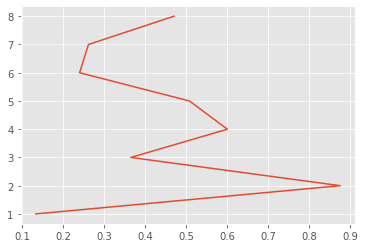

In [ ]:
samples=binary_sample(8)
plt.plot(samples,[1,2,3,4,5,6,7,8])
# plt.plot(rough_2(samples))
samples

(array([0.24081167]), array([0.02652595]))


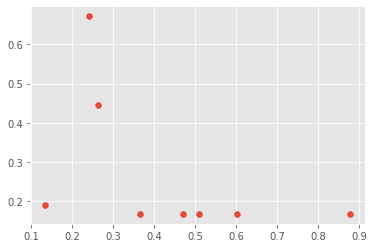

In [ ]:
plt.scatter(samples,rough_2(samples))
print(find_nearest(samples, 3/14))

In [ ]:
def run_experiment(function, participants, sample_no, strategy):
    plt.figure(dpi=150)
    pooled_x = []
    pooled_y = []
    mse = []
    ad_peak =[]
    
    obj_func = None
    if function == "rough_1":
        obj_func = rough_1
    if function == "rough_2":
        obj_func = rough_2
    if function == "rough_3":
        obj_func = rough_3
    if function == "rough_4":
        obj_func = rough_4
    if function == "smooth_1":
        obj_func = smooth_1
    if function == "smooth_2":
        obj_func = smooth_2
    if function == "smooth_3":
        obj_func = smooth_3
    if function == "smooth_4":
        obj_func = smooth_4
    if function == "flat":
        obj_func = flat
    
    MIN = 0
    MAX = 1
    x_t = np.linspace(MIN, MAX, 500)
    y_t = obj_func(x_t)
    plt.plot(x_t, y_t, "k--", linewidth=2, label="Actual function")

    pred_mean = []
    for i in range(participants):
        x = []
        # Sample  points based on strategy:
        if strategy == "Uniform":
            x = uniform_sample(sample_no)
        if strategy == "Sequential":
            x = sequential_sample(sample_no)
        if strategy == "Resample":
            x = resample_seq(sample_no, objective_func=obj_func)
        if strategy == "Binary":
            x = binary_sample(sample_no)
        if strategy == "Thompson":
            x = bootstrap_gpsample_uncertainty_minimizer(sample_no, obj_func, num_posterior_samples=2, kernel=K)
        if strategy == "Human":
            if i % 10 == 0:
                print(f"Modelling participant {i}...")
            x = load_samples(function, uid=i)["Samples"]["x"].values.reshape(-1, 1)

        # Calculate target y based on function:
        if function == "rough_1":
            y, peak = rough_1(x), 13/15
        if function == "rough_2":
            y, peak = rough_2(x), 3/14
        if function == "rough_3":
            y, peak = rough_3(x), 14/26
        if function == "rough_4":
            y, peak = rough_4(x), 0.78
        if function == "smooth_1":
            y, peak = smooth_1(x), 0
        if function == "smooth_2":
            y, peak = smooth_2(x),  2/3
        if function == "smooth_3":
            y, peak = smooth_3(x),1
        if function == "smooth_4":
            y, peak = smooth_4(x), 1/4
        if function == "flat":
            y = flat(x)
        pooled_x.append(x)
        pooled_y.append(y)

        ad_peak.append(find_nearest(x, peak)[1])

        # Fit a GP:
        # let us use the Matern kernel

        gp = gaussian_process.GaussianProcessRegressor(kernel=K)
        gp.fit(x, y)

        mse.append(
            metrics.mean_squared_error(
                y_true=y_t, y_pred=gp.predict(x_t.reshape(-1, 1))
            )
        )

        # Visualisation
        # plt.plot(x, y, 'bo', label="""Random Samples""", alpha=0.7)
        y_mean, y_std = gp.predict(x_t.reshape(-1, 1), return_std=True)
        pred_mean.append(y_mean)
        plt.plot(x_t, y_mean, "r", linewidth=1, alpha=0.2)

    pooled_function_means = np.array(pred_mean)[:, :, 0].mean(axis=0)

    # Fit pooled model
    gp_pooled = gaussian_process.GaussianProcessRegressor(kernel=K)
    gp_pooled.fit(np.array(pooled_x).reshape(-1, 1), np.array(pooled_y).reshape(-1, 1))
    y_mean2, y_std2 = gp_pooled.predict(x_t.reshape(-1, 1), return_std=True)
    plt.plot(
        x_t, pooled_function_means, "b", linewidth=2, label="Average Gaussian Process Fit", alpha=0.7
    )
    y_1, y_2 = (y_mean2 - y_std2), (y_mean2 + y_std2)
    avg_mse = np.mean(mse)
    pool_mse = metrics.mean_squared_error(
        y_true=y_t, y_pred=pooled_function_means)
    mean_mad = np.mean(ad_peak)
    r = np.corrcoef(y_t, pooled_function_means)[0,1]
    # plt.fill_between(x_t,y_1,y_2, color='b', alpha=0.2)
    print(
        f"############################################################################################\n"
        f"                                {function} FIT EXPERIMENT COMPLETE                          \n"
        f"                  Average MSE = {avg_mse}, Pooled MSE = {pool_mse}                          \n"
        f"                                 Sampling Strategy : {strategy}                             \n"
        f"                                 Mean Absolute Distance From Maxima : {mean_mad}             \n"
        f"############################################################################################\n"
    )
    plt.legend(loc="upper left")
    if function == "rough_2":
        plt.legend(loc="upper right")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

array([[0.0284306 ],
       [0.15899863],
       [0.3691498 ],
       [0.34561635],
       [0.51674378],
       [0.65092511],
       [1.54085088],
       [1.5385927 ]])

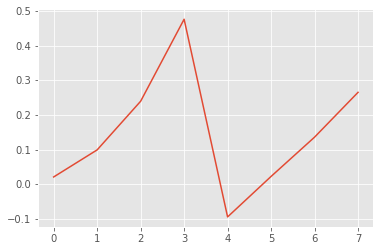

Modelling participant 0...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarnin

Modelling participant 10...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ga

Modelling participant 20...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarnin

Modelling participant 30...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ga

Modelling participant 40...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarnin

Modelling participant 50...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarnin

Modelling participant 60...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ga

Modelling participant 70...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/ga

Modelling participant 80...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarnin

############################################################################################
                                smooth_4 FIT EXPERIMENT COMPLETE                          
                  Average MSE = 0.33197478156826504, Pooled MSE = 0.18558790907164138                          
                                 Sampling Strategy : Human                             
                                 Mean Absolute Distance From Maxima : 0.0422365250212423             
############################################################################################



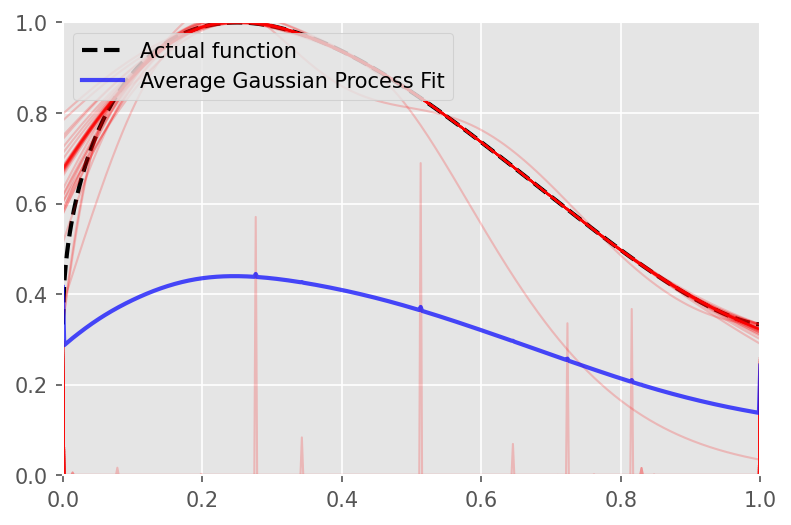

In [ ]:
K = kernels.Matern(length_scale = 1, nu = 3)
run_experiment("smooth_4", 89, 8, "Human")  

Drawing participant 1...
Drawing participant 11...
Drawing participant 21...
Drawing participant 31...
Drawing participant 41...
Drawing participant 51...
Drawing participant 61...
Drawing participant 71...
Drawing participant 81...


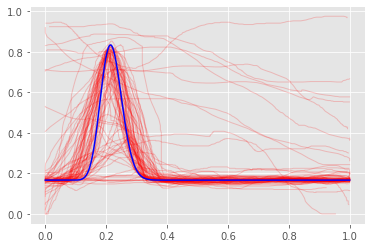

In [ ]:
for i in range(89):
    if i % 10 == 1:
        print(f"Drawing participant {i}...")
    preds = load_preds("rough_2", i)
    p_x = preds["Predictions"]["x"].values.reshape(-1, 1)
    p_y = preds["Predictions"]["y"].values.reshape(-1, 1)
    plt.plot(p_x, p_y, "r", linewidth=1, alpha = 0.2)
p_xt = load_preds("rough_2", 1)["Predictions"]["x"].values.reshape(-1, 1)
p_yt = rough_2(p_xt)
plt.plot(p_xt, p_yt, "b")

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], np.abs(array[idx] - value)